In [1]:
%pylab inline
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
data = []
datapath = '/home/bigdatas16/1216.csv'
data = pd.read_csv(datapath)
def MA(data,day):
    dataList = range(data['Date'].size)
    tmpList = []
    for i in dataList:
        if i - day + 1 >= 0:
            # 移動平均數 = 採樣天數的股價合計 / 採樣天數
            tmp = data['Close'][i-day+1:i+1].mean()
            tmpList.append(tmp)
        elif i - day + 1 < 0:
            tmp = 0
            tmpList.append(tmp)
    tmpSeries = pd.Series(tmpList)
    data['MA'+str(day)]=tmpSeries
# 乖離率(BIAS)
def BIAS_lag(data,day):
    dataList = range(data['Date'].size)
    tmpList = []
    tmpList.append(0)
    for item in dataList:
        if item-day+1 >= 0:
            tmp = (data['Close'][item]-data['MA'+str(day)][item])/(data['MA'+str(day)][item])*100
            tmpList.append(tmp)
        elif item - day + 1 < 0:
            tmp = 0
            tmpList.append(tmp)         
    tmpSeries = pd.Series(tmpList)
    data['BIAS'+str(day)] = tmpSeries
for i in range(24):
    MA(data,1+i)
    BIAS_lag(data,1+i)
#data = data.drop(data.index[4620])
def UP_DOWN(data):
    data_day_number = range(data['Date'].size)
    tmpList = []
    
    for item in data_day_number:
        spread = data['Close'][item] - data['Open'][item]
        if spread > 0 :
            tmp = 1
        elif spread <= 0:
            tmp = 0
 
        tmpList.append(tmp)
    
    tmpSeries = pd.Series(tmpList)
    data['UP_DOWN']=tmpSeries
UP_DOWN(data)
data1 = data.drop(['Date', 'Open', 'High','Low','Close','Volume_n','Volume_m','return','PE','MA1','MA2','MA3','MA4','MA5','MA6','MA7','MA8','MA9','MA10','MA11','MA12','MA13','MA14','MA15','MA16','MA17','MA18','MA19','MA20','MA21','MA22','MA23','MA24'], axis=1)
data1 = data1.fillna(-1)
cols = data1.columns.tolist()
cols[24]
data1 = data1[[cols[24]] + cols[0:23]]
n = len(data['Date'])/5
m = len(data['Date']) - n
train_data = data1.iloc[:m,:]

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(iris.target_names))
    #plt.xticks(tick_marks, iris.target_names, rotation=45)
    #plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

hyperparametr tuning cross validation 5 folds

In [3]:
#%pylab inline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
import time 
sql_sc = SQLContext(sc)
train_data.iloc[:(m/5),:]
train_data.iloc[(m/5):(2*m/5),:]
train_data.iloc[(2*m/5):(3*m/5),:]
train_data.iloc[(3*m/5):(5*m/5),:]
train_data.iloc[(4*m/5):m,:]

cross_data_list = [i for i in range(1,6)]
cross_data_list[0] = train_data.iloc[:(m/5),:]
cross_data_list[1] = train_data.iloc[(m/5):(2*m/5),:]
cross_data_list[2] = train_data.iloc[(2*m/5):(3*m/5),:]
cross_data_list[3] = train_data.iloc[(3*m/5):(5*m/5),:]
cross_data_list[4] = train_data.iloc[(4*m/5):m,:]
cross_data_pandas = [i for i in range(1,6)]
for i in range(0,5,1):
    cross_data_pandas[i] = pd.DataFrame(cross_data_list[i])
#cross_data_pandas[4]

cross_sql = [i for i in range(1,6)]
for i in range(0,5,1):
    cross_sql[i] = sql_sc.createDataFrame(cross_data_pandas[i])


assembler1 = VectorAssembler(inputCols=["BIAS1", "BIAS2", "BIAS3","BIAS4","BIAS5","BIAS6"
                                       ,"BIAS7","BIAS8","BIAS9","BIAS10","BIAS11","BIAS12"
                                       ,"BIAS13","BIAS14","BIAS15","BIAS16","BIAS17","BIAS18"
                                       ,"BIAS19","BIAS20","BIAS21","BIAS22","BIAS23"],outputCol="features")
for i in range(0,5,1):
    cross_sql[i] = assembler1.transform(cross_sql[i])
    
frames = [i for i in range(1,6)]
for i in range(0,5):
    #print(i)
    frames[i] = pd.concat([cross_data_pandas[(i+1)%5],cross_data_pandas[(i+2)%5],cross_data_pandas[(i+3)%5],cross_data_pandas[(i+4)%5]])
    result_sql = [i for i in range(1,6)]

for i in range(0,5):   
    result_sql[i] = sql_sc.createDataFrame(frames[i])   
    
assembler1 = VectorAssembler(inputCols=["BIAS1", "BIAS2", "BIAS3","BIAS4","BIAS5","BIAS6"
                                       ,"BIAS7","BIAS8","BIAS9","BIAS10","BIAS11","BIAS12"
                                       ,"BIAS13","BIAS14","BIAS15","BIAS16","BIAS17","BIAS18"
                                       ,"BIAS19","BIAS20","BIAS21","BIAS22","BIAS23"],outputCol="features")
for i in range(0,5):  
    result_sql[i] = assembler1.transform(result_sql[i])

start = time.time()

cv5_test_error = []    
maxBins_numTrees_maxDepth = []    
for l in range(15,35,5):
    for j in range(1,8,1):
        for k in range(1,10,1):
            Test_Error = []
            for i in range(0,5):
                labelIndexer = StringIndexer(inputCol = "UP_DOWN", outputCol="indexedLabel").fit(result_sql[i])
                featureIndexer = VectorIndexer(inputCol = "features", outputCol="indexedFeatures").fit(result_sql[i])
                #rf = RandomForestClassifier(labelCol="labelIndexer", featuresCol="features")
                rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures",numTrees = k,maxDepth = j,maxBins = l)
                # Chain indexers and forest in a Pipeline
                pipeline = Pipeline(stages=[labelIndexer,featureIndexer,rf])
                model = pipeline.fit(result_sql[i])
                predictions = model.transform(cross_sql[i])
                evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel"
                                                              , predictionCol="prediction",metricName = "precision")
                accuracy = evaluator.evaluate(predictions)
                print("[%g,%g,%g] : Test Error(%d) = %g" % (k,j,l,i,1.0 - accuracy))
                Test_Error.append(1.0 - accuracy)
            cv5_test_error.append(mean(Test_Error))
            maxBins_numTrees_maxDepth.append([k,j,l])

end = time.time()
print "Cross Validation 5 Folds Hyperparameter Tuning : Time taken = %f second"%(end - start)
        
    
mintest = np.min(cv5_test_error)
c = []
for i in range(len(cv5_test_error)):
    c.append(np.min(cv5_test_error) == cv5_test_error[i])
    
for i in range(len(cv5_test_error)):    
    if c[i] == True:
        print(maxBins_numTrees_maxDepth[i],mintest)       

Populating the interactive namespace from numpy and matplotlib
[1,1,15] : Test Error(0) = 0.362652
[1,1,15] : Test Error(1) = 0.385656
[1,1,15] : Test Error(2) = 0.428958
[1,1,15] : Test Error(3) = 0.404327
[1,1,15] : Test Error(4) = 0.410811
[2,1,15] : Test Error(0) = 0.345061
[2,1,15] : Test Error(1) = 0.388363
[2,1,15] : Test Error(2) = 0.423545
[2,1,15] : Test Error(3) = 0.425287
[2,1,15] : Test Error(4) = 0.414865
[3,1,15] : Test Error(0) = 0.345061
[3,1,15] : Test Error(1) = 0.37889
[3,1,15] : Test Error(2) = 0.414073
[3,1,15] : Test Error(3) = 0.40906
[3,1,15] : Test Error(4) = 0.42027
[4,1,15] : Test Error(0) = 0.341001
[4,1,15] : Test Error(1) = 0.381597
[4,1,15] : Test Error(2) = 0.41272
[4,1,15] : Test Error(3) = 0.407708
[4,1,15] : Test Error(4) = 0.418919
[5,1,15] : Test Error(0) = 0.341001
[5,1,15] : Test Error(1) = 0.374831
[5,1,15] : Test Error(2) = 0.415426
[5,1,15] : Test Error(3) = 0.40906
[5,1,15] : Test Error(4) = 0.417568
[6,1,15] : Test Error(0) = 0.364005
[6,1,1

predict

In [4]:
train_data = data1.iloc[:m,:]
train_sql = sql_sc.createDataFrame(train_data)
test_data = data1.iloc[m:,:]
test_sql = sql_sc.createDataFrame(test_data)

assembler1 = VectorAssembler(inputCols=["BIAS1", "BIAS2", "BIAS3","BIAS4","BIAS5","BIAS6"
                                        ,"BIAS7","BIAS8","BIAS9","BIAS10","BIAS11","BIAS12"
                                        ,"BIAS13","BIAS14","BIAS15","BIAS16","BIAS17","BIAS18"
                                        ,"BIAS19","BIAS20","BIAS21","BIAS22","BIAS23"],outputCol="features")
train_sql = assembler1.transform(train_sql)
labelIndexer = StringIndexer(inputCol = "UP_DOWN", outputCol="indexedLabel").fit(train_sql)
featureIndexer = VectorIndexer(inputCol = "features", outputCol="indexedFeatures").fit(train_sql)
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures",numTrees = 5,maxDepth = 1,maxBins = 15)
pipeline = Pipeline(stages=[labelIndexer,featureIndexer,rf])
model = pipeline.fit(train_sql)
assembler = VectorAssembler(inputCols=["BIAS1", "BIAS2", "BIAS3","BIAS4","BIAS5","BIAS6"
                                        ,"BIAS7","BIAS8","BIAS9","BIAS10","BIAS11","BIAS12"
                                        ,"BIAS13","BIAS14","BIAS15","BIAS16","BIAS17","BIAS18"
                                        ,"BIAS19","BIAS20","BIAS21","BIAS22","BIAS23"],outputCol="features")
test_sql = assembler.transform(test_sql)
predictions = model.transform(test_sql)

In [5]:
prediction_1101 = predictions.select("prediction", "indexedLabel")
prediction_1101_pandas = prediction_1101.toPandas()
cm = confusion_matrix(prediction_1101_pandas['indexedLabel'], prediction_1101_pandas['prediction'])
pd.crosstab(prediction_1101_pandas['indexedLabel'], prediction_1101_pandas['prediction'], rownames=['actual'], colnames=['preds'])

preds,0.0,1.0
actual,,
0.0,499,4
1.0,417,4


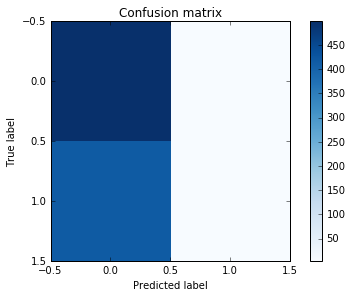

In [8]:
plot_confusion_matrix(cm)
plt.show()

In [6]:
pd.DataFrame(["BIAS1", "BIAS2", "BIAS3","BIAS4","BIAS5","BIAS6"
             ,"BIAS7","BIAS8","BIAS9","BIAS10","BIAS11","BIAS12"
             ,"BIAS13","BIAS14","BIAS15","BIAS16","BIAS17","BIAS18"
             ,"BIAS19","BIAS20","BIAS21","BIAS22","BIAS23"])

,0
0,BIAS1
1,BIAS2
2,BIAS3
3,BIAS4
4,BIAS5
5,BIAS6
6,BIAS7
7,BIAS8
8,BIAS9
9,BIAS10


In [7]:
print(model.stages[2]._call_java('toDebugString'))

RandomForestClassificationModel (uid=rfc_1d9c7e3b0764) with 5 trees
  Tree 0 (weight 1.0):
    If (feature 8 <= -1.0298037315241027)
     Predict: 0.0
    Else (feature 8 > -1.0298037315241027)
     Predict: 0.0
  Tree 1 (weight 1.0):
    If (feature 3 <= -1.8618121638394676)
     Predict: 1.0
    Else (feature 3 > -1.8618121638394676)
     Predict: 0.0
  Tree 2 (weight 1.0):
    If (feature 6 <= -3.8691393013369315)
     Predict: 1.0
    Else (feature 6 > -3.8691393013369315)
     Predict: 0.0
  Tree 3 (weight 1.0):
    If (feature 4 <= -3.2622333751568284)
     Predict: 1.0
    Else (feature 4 > -3.2622333751568284)
     Predict: 0.0
  Tree 4 (weight 1.0):
    If (feature 11 <= -2.389318341531992)
     Predict: 1.0
    Else (feature 11 > -2.389318341531992)
     Predict: 0.0



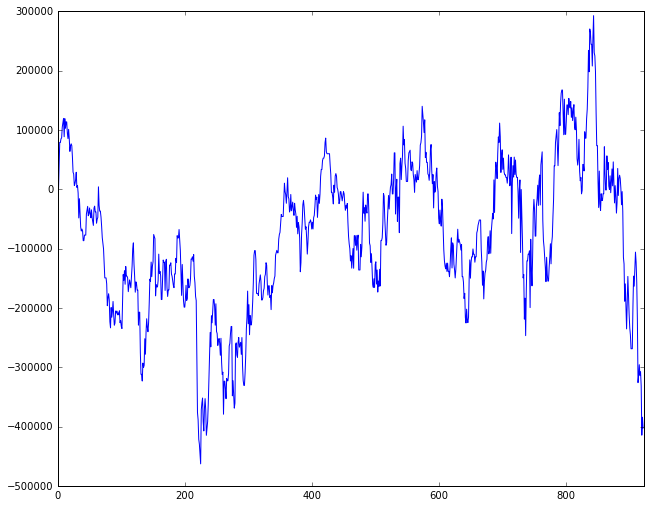

In [9]:
data_p = data[['Close','Open']][(4621-n):4622].values
data_p1 = pd.DataFrame(data_p,columns = ['Close','Open'])
result = np.c_[prediction_1101_pandas['indexedLabel'],prediction_1101_pandas['prediction']]
result1 = pd.DataFrame(result , columns = ['test', 'prediction'])
result2 = pd.concat([data_p1, result1], axis=1)
result2["Cl - Op"] = result2['Close'] - result2['Open']
result2['prediction'] = result2['prediction'].replace(0,-1)
result2['profit'] = 1000*result2['Open'] * result2['Cl - Op'] * result2['prediction']
a = result2['profit'].cumsum()
from IPython.core.pylabtools import figsize
figsize(10.5, 8.5)
a.plot()

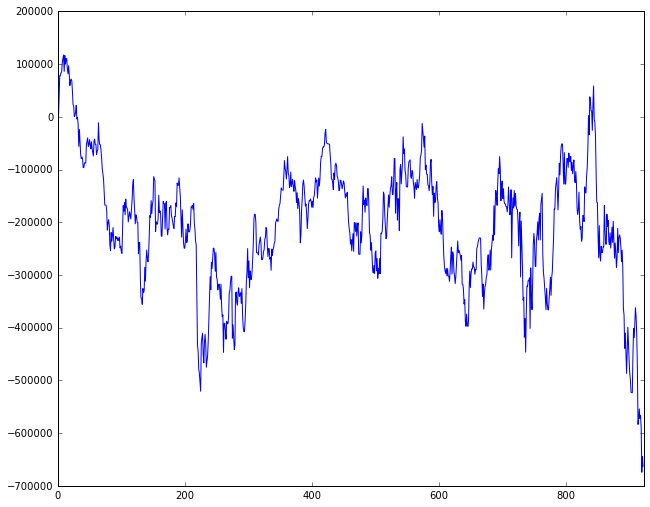

In [10]:
result2['processing fee1'] = np.where(result2['prediction'] == 1,1000*(result2['Close']*(4.425/1000.0) + result2['Open']*(1.425/1000.0))*1
                                      ,1000*(result2['Close']*(1.425/1000.0) + result2['Open']*(4.425/1000.0)))
result2['profit_r_fee'] = result2['profit'] -  result2['processing fee1']
b = result2['profit_r_fee'].cumsum()
from IPython.core.pylabtools import figsize
figsize(10.5, 8.5)
b.plot()

In [11]:
data_p = data[['Close','Open']][(4621-n):4622].values
data_p1 = pd.DataFrame(data_p,columns = ['Close','Open'])
result = np.c_[prediction_1101_pandas['indexedLabel'],prediction_1101_pandas['prediction']]
result1 = pd.DataFrame(result , columns = ['test', 'prediction'])
result2 = pd.concat([data_p1, result1], axis=1)
result2["Cl - Op"] = result2['Close'] - result2['Open']
result2['prediction'] = result2['prediction'].replace(0,-1)
result2['profit'] = 1000*result2['Open'] * result2['Cl - Op'] * result2['prediction']
data_PE = data[['PE']][(4621-n):4622].values
data_PE = pd.DataFrame(data_PE,columns = ['PE'])
result2 = pd.concat([data_PE, result2], axis=1)
result2['profit2'] = 0.0
result2['profit2'][0] = 0 
for i in range(5,len(result2)-1,1):
    if result2['prediction'][i+1] == 1 and result2['prediction'][i] == -1 and result2['PE'][i] < result2['PE'][i-5:i-1].mean():
        result2['profit2'][i+1] = result2['profit2'][i] + 1000 * (-1) * result2['Open'][i+1]
    elif result2['prediction'][i+1] == 1 and result2['prediction'][i] == 1:
        result2['profit2'][i+1] = result2['profit2'][i] 
    elif result2['prediction'][i+1] == -1 and result2['prediction'][i] == 1 and result2['PE'][i] > result2['PE'][i-5:i-1].mean():
        result2['profit2'][i+1] = result2['profit2'][i] + 1000 * result2['Open'][i+1]
    elif result2['prediction'][i+1] == -1 and result2['prediction'][i] == -1:
        result2['profit2'][i+1] = result2['profit2'][i] 

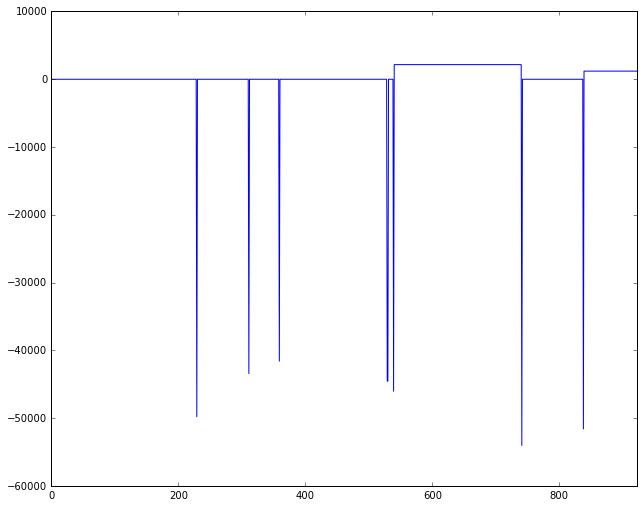

In [12]:
result2['profit2'].plot()

In [13]:
result2['processing_fee_2'] = 0.0
result2['processing_fee_2'][0] = 0#(-1) * result2['Open'][0]

for i in range(5,len(result2)-1,1):
    if result2['prediction'][i+1] == 1 and result2['prediction'][i] == -1 and result2['PE'][i] < result2['PE'][i-5:i-1].mean():
        result2['processing_fee_2'][i+1] = result2['processing_fee_2'][i] + 1000 * (-1) * result2['Open'][i+1] - (1000 * result2['Open'][i+1])*((1.425/1000.0))
    elif result2['prediction'][i+1] == 1 and result2['prediction'][i] == 1:
        result2['processing_fee_2'][i+1] = result2['processing_fee_2'][i]
    elif result2['prediction'][i+1] == -1 and result2['prediction'][i] == 1 and result2['PE'][i] > result2['PE'][i-5:i-1].mean():
        result2['processing_fee_2'][i+1] = result2['processing_fee_2'][i] + 1000 * result2['Open'][i+1] - (1000 * result2['Open'][i+1])*(4.425/1000.0)
    elif result2['prediction'][i+1] == -1 and result2['prediction'][i] == -1:
        result2['processing_fee_2'][i+1] = result2['processing_fee_2'][i]

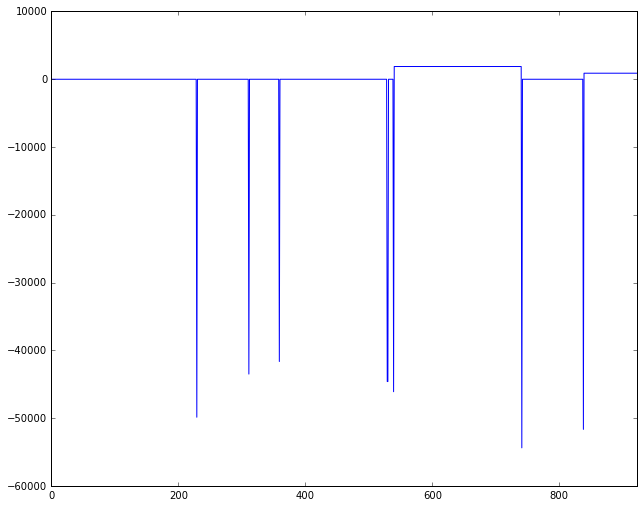

In [14]:
result2['processing_fee_2'].plot()#[1101:2301].plot()